# Advanced pipeline

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("data/german-credit-data.csv", index_col=0)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [3]:
df.dtypes

Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
Risk                object
dtype: object

In [4]:
df.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In every model we have created so far, we have always made sure that the data received by the estimators did not have the following two carecteristics:

- missing data (NaN)
- non-numerical data (str)

By this point, we already understand why this is the case: estimators depend on learning algorithms, which, in one way or another, perform **mathematical calculations** in the learning process. Therefore, it is natural that the data provided to the estimator must be all numeric and without "holes". Until now, we have followed the simplest path, which is: simply eliminate non-numeric columns, and columns/lines that have NaNs.

Despite this being a possible approach, it is not the best one. In this notebook, we will learn how to use the `sklearn.pipeline` module to create a pipeline that will handle the data in a more intelligent way.

In [5]:
X_cat = df.select_dtypes(exclude=np.number).drop(columns="Risk")

In [6]:
X_cat["Housing"].value_counts()

own     713
rent    179
free    108
Name: Housing, dtype: int64

In [19]:
X_cat["Housing"].astype("category").cat.codes.value_counts()

1    713
2    179
0    108
dtype: int64

In [10]:
pd.get_dummies(X_cat["Housing"]).head()

,free,own,rent
0,0,1,0
1,0,1,0
2,0,1,0
3,1,0,0
4,1,0,0


In [13]:
X_cat.isnull().sum()

Sex                   0
Housing               0
Saving accounts     183
Checking account    394
Purpose               0
dtype: int64

In [14]:
X_cat["Saving accounts"].value_counts(dropna=False)

little        603
NaN           183
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64

In [16]:
X_cat["Saving accounts"].fillna("unknown")[:5]

0    unknown
1     little
2     little
3     little
4     little
Name: Saving accounts, dtype: object

In [17]:
X_cat["Saving accounts"].mode()

0    little
Name: Saving accounts, dtype: object

In [18]:
X_cat["Saving accounts"].fillna(X_cat["Saving accounts"].mode())[:5]

0    little
1    little
2    little
3    little
4    little
Name: Saving accounts, dtype: object

In practice, this is what we will do with sklearn, as a step in the pipeline.

Before going any further, let's do the train-test split -- but this time with all features, as well as missing data.

In [20]:
from sklearn.model_selection import train_test_split

X = df.drop(columns="Risk")
y = df["Risk"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Filling NaNs with sklearn

In the [sklearn.impute](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.impute) submodule, there are some classes that are used to fill (input) NaN data. Consider reading the [User Guide](https://scikit-learn.org/stable/modules/impute.html) for more details on the inputers.

We will use the [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer), which fills the data in a column from descriptive statistics of the data in that column -- in our case, the columns with NaNs are categorical columns. Therefore, the NaNs will be filled **with the mode** of each column.

The inputers behave like transformers, with respect to the `.fit()` and `.transform()` methods. For this reason, it is also very important that they **be fitted only on the training data**.

The pipeline will ensure this for us automatically.

In [21]:
df.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [23]:
from sklearn.impute import SimpleImputer

inputer_constant = SimpleImputer(strategy="constant", fill_value="none").fit(X_train)
inputer_mode = SimpleImputer(strategy="most_frequent").fit(X_train)

In [24]:
display(X_train["Saving accounts"].value_counts(dropna=False))
display(X_train["Checking account"].value_counts(dropna=False))

little        480
NaN           149
moderate       87
quite rich     48
rich           36
Name: Saving accounts, dtype: int64

NaN         323
little      225
moderate    201
rich         51
Name: Checking account, dtype: int64

In [25]:
X_train_inputed_constant = pd.DataFrame(inputer_constant.transform(X_train), columns=X_train.columns)

display(X_train_inputed_constant["Saving accounts"].value_counts(dropna=False))
display(X_train_inputed_constant["Checking account"].value_counts(dropna=False))

little        480
none          149
moderate       87
quite rich     48
rich           36
Name: Saving accounts, dtype: int64

none        323
little      225
moderate    201
rich         51
Name: Checking account, dtype: int64

In [26]:
X_train_inputed_mode = pd.DataFrame(inputer_mode.transform(X_train), columns=X_train.columns)

display(X_train_inputed_mode["Saving accounts"].value_counts(dropna=False))
display(X_train_inputed_mode["Checking account"].value_counts(dropna=False))

little        629
moderate       87
quite rich     48
rich           36
Name: Saving accounts, dtype: int64

little      548
moderate    201
rich         51
Name: Checking account, dtype: int64


In practice, we will **add the inputer as part of our Pipeline**, and, with that, we will ensure that data leakage will not happen.

Note that the SKLearn will transform all columns into `object` type data. This is because the inputer was fitted **with all columns**, which includes the numerical ones as well. In order to avoid this, it would be nice to use the inputer **only in certain columns**.

## Using cathegorical data with SKLearn

The relevant classes are:

- [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder)
- [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder)

Both encoders also work with the `.fit()` and `.transform()` methods, so it is also a good idea to put them **as the initial step of the Pipeline**.

In [29]:
X_train_inputed_mode[['Age', 'Job', 'Duration', 'Credit amount']] = X_train_inputed_mode[['Age', 'Job', 'Duration', 'Credit amount']].astype(int)

In [30]:
X_train_inputed_mode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               800 non-null    int64 
 1   Sex               800 non-null    object
 2   Job               800 non-null    int64 
 3   Housing           800 non-null    object
 4   Saving accounts   800 non-null    object
 5   Checking account  800 non-null    object
 6   Credit amount     800 non-null    int64 
 7   Duration          800 non-null    int64 
 8   Purpose           800 non-null    object
dtypes: int64(4), object(5)
memory usage: 56.4+ KB


In [31]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

encoder_oh = OneHotEncoder().fit(X_train_inputed_mode.select_dtypes(exclude=np.number))
encoder_oe = OrdinalEncoder().fit(X_train_inputed_mode.select_dtypes(exclude=np.number))

In [33]:
pd.DataFrame(encoder_oh.transform(X_train_inputed_mode.select_dtypes(exclude=np.number)).toarray()).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [34]:
aux = pd.DataFrame(encoder_oe.transform(X_train_inputed_mode.select_dtypes(exclude=np.number)))
aux.head()

,0,1,2,3,4
0,0.0,2.0,0.0,0.0,5.0
1,1.0,1.0,1.0,1.0,0.0
2,0.0,1.0,0.0,1.0,5.0
3,1.0,1.0,0.0,1.0,4.0
4,0.0,2.0,1.0,0.0,4.0


In [35]:
aux[1].value_counts()

1.0    579
2.0    139
0.0     82
Name: 1, dtype: int64

In [36]:
X_train["Housing"].value_counts()

own     579
rent    139
free     82
Name: Housing, dtype: int64

## Advanced pipelines

In [37]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

In [40]:
df = pd.read_csv("data/german-credit-data.csv", index_col=0)

X = df.drop(columns="Risk")
y = df["Risk"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ==========================================================

pipe_features_num = Pipeline([("input_num", SimpleImputer(strategy="mean")),
                              ("std", StandardScaler())])

features_num = X_train.select_dtypes(include=np.number).columns.tolist()

# ==========================================================

pipe_features_cat = Pipeline([("input_cat", SimpleImputer(strategy="constant", fill_value="unknown")),
                              ("onehot", OneHotEncoder())])

features_cat = X_train.select_dtypes(exclude=np.number).columns.tolist()

# ==========================================================

pre_processor = ColumnTransformer([("transf_num", pipe_features_num, features_num),
                                   ("transf_cat", pipe_features_cat, features_cat)])

pipe = Pipeline([("pre_processor", pre_processor),
                 ("dt", DecisionTreeClassifier(random_state=42))])

# ============================================

params_grid_dt = {"dt__criterion" : ["gini", "entropy"],
                  "dt__splitter" : ["best", "random"],
                  "dt__max_depth" : range(2, 11)} 

splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_dt = GridSearchCV(estimator=pipe,
                       param_grid=params_grid_dt,
                       scoring="f1_weighted",
                       cv=splitter)

grid_dt.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('pre_processor',
                                        ColumnTransformer(transformers=[('transf_num',
                                                                         Pipeline(steps=[('input_num',
                                                                                          SimpleImputer()),
                                                                                         ('std',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Job',
                                                                          'Credit '
                                                                          'amount',
                                                                          'Duration']),
                                                                        ('transf_cat',
                                                                         Pipeline(steps=[('input_cat',
                                                                                          SimpleImputer(fill_value='unknown',
                                                                                                        strategy='constant')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['Sex',
                                                                          'Housing',
                                                                          'Saving '
                                                                          'accounts',
                                                                          'Checking '
                                                                          'account',
                                                                          'Purpose'])])),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'dt__criterion': ['gini', 'entropy'],
                         'dt__max_depth': range(2, 11),
                         'dt__splitter': ['best', 'random']},
             scoring='f1_weighted')

In [42]:
grid_dt.best_params_

{'dt__criterion': 'entropy', 'dt__max_depth': 5, 'dt__splitter': 'random'}


Train evaluation metrics:


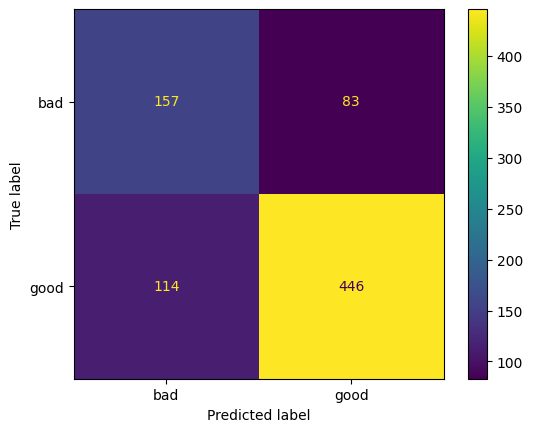

              precision    recall  f1-score   support

         bad       0.58      0.65      0.61       240
        good       0.84      0.80      0.82       560

    accuracy                           0.75       800
   macro avg       0.71      0.73      0.72       800
weighted avg       0.76      0.75      0.76       800


Test evaluation metrics:


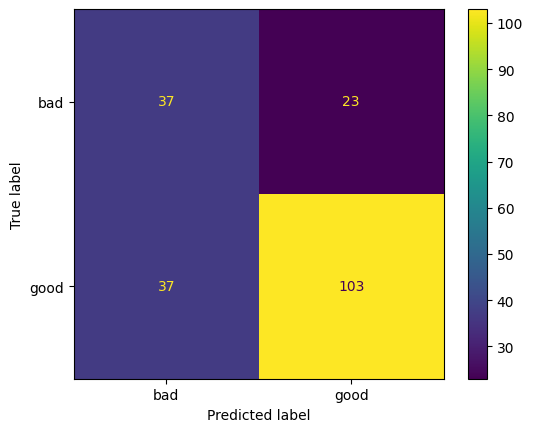

              precision    recall  f1-score   support

         bad       0.50      0.62      0.55        60
        good       0.82      0.74      0.77       140

    accuracy                           0.70       200
   macro avg       0.66      0.68      0.66       200
weighted avg       0.72      0.70      0.71       200



In [43]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# ============================================

print("\nTrain evaluation metrics:")

y_pred_train = grid_dt.predict(X_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.show()
print(classification_report(y_train, y_pred_train))

# ============================================

print("\nTest evaluation metrics:")

y_pred_test = grid_dt.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()
print(classification_report(y_test, y_pred_test))

In [44]:
X_train.select_dtypes(exclude=np.number).columns.tolist()

['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']

In [45]:
X_train["Purpose"].value_counts()

car                    267
radio/TV               225
furniture/equipment    150
business                78
education               44
repairs                 20
domestic appliances      8
vacation/others          8
Name: Purpose, dtype: int64

In [47]:
# ==========================================================

pipe_features_num = Pipeline([("input_num", SimpleImputer(strategy="mean")),
                              ("std", StandardScaler())])

features_num = X_train.select_dtypes(include=np.number).columns.tolist()

# ==========================================================

pipe_features_oh = Pipeline([("input_cat_oh", SimpleImputer(fill_value="unknown")),
                             ("onehot", OneHotEncoder())])

features_oh = ['Sex', 'Purpose']

# ==========================================================

pipe_features_oe = Pipeline([("input_cat_oe", SimpleImputer(strategy="constant", fill_value="unknown")),
                             ("ordinal", OrdinalEncoder())])

features_oe = ['Housing', 'Saving accounts', 'Checking account']

# ==========================================================

pre_processor = ColumnTransformer([("transf_num", pipe_features_num, features_num),
                                     ("transf_cat_oh", pipe_features_oh, features_oh),
                                     ("transf_cat_oe", pipe_features_oe, features_oe)])

pipe = Pipeline([("pre_processor", pre_processor),
                 ("dt", DecisionTreeClassifier(random_state=42))])

# ============================================

params_grid_dt = {"pre_processor__transf_cat_oh__input_cat_oh__strategy": ["constant", "most_frequent"], 
                  "dt__criterion" : ["gini", "entropy"],
                  "dt__splitter" : ["best", "random"],
                  "dt__max_depth" : range(2, 11)} 

splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_dt = GridSearchCV(estimator=pipe,
                       param_grid=params_grid_dt,
                       scoring="f1_weighted",
                       cv=splitter)

grid_dt.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('pre_processor',
                                        ColumnTransformer(transformers=[('transf_num',
                                                                         Pipeline(steps=[('input_num',
                                                                                          SimpleImputer()),
                                                                                         ('std',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Job',
                                                                          'Credit '
                                                                          'amount',
                                                                          'Duration']),
                                                                        ('transf_cat_oh',
                                                                         Pipeline(steps=[('input_cat_oh',
                                                                                          SimpleImputer(fill_valu...
                                                                                         ('ordinal',
                                                                                          OrdinalEncoder())]),
                                                                         ['Housing',
                                                                          'Saving '
                                                                          'accounts',
                                                                          'Checking '
                                                                          'account'])])),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'dt__criterion': ['gini', 'entropy'],
                         'dt__max_depth': range(2, 11),
                         'dt__splitter': ['best', 'random'],
                         'pre_processor__transf_cat_oh__input_cat_oh__strategy': ['constant',
                                                                                  'most_frequent']},
             scoring='f1_weighted')

In [48]:
grid_dt.best_params_

{'dt__criterion': 'entropy',
 'dt__max_depth': 6,
 'dt__splitter': 'random',
 'pre_processor__transf_cat_oh__input_cat_oh__strategy': 'constant'}


Train evaluation metrics:


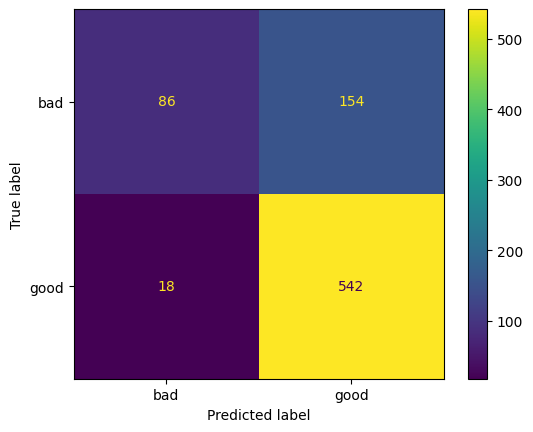

              precision    recall  f1-score   support

         bad       0.83      0.36      0.50       240
        good       0.78      0.97      0.86       560

    accuracy                           0.79       800
   macro avg       0.80      0.66      0.68       800
weighted avg       0.79      0.79      0.75       800


Test evaluation metrics:


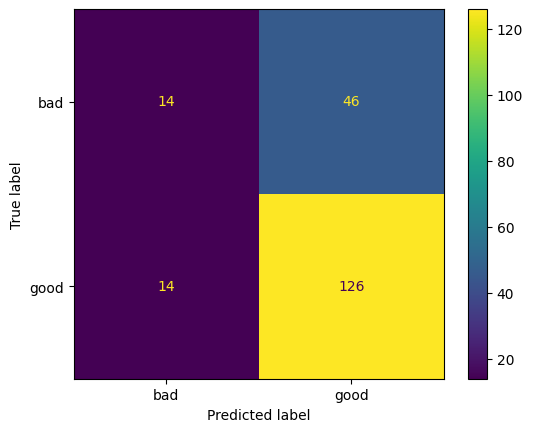

              precision    recall  f1-score   support

         bad       0.50      0.23      0.32        60
        good       0.73      0.90      0.81       140

    accuracy                           0.70       200
   macro avg       0.62      0.57      0.56       200
weighted avg       0.66      0.70      0.66       200



In [49]:
# ============================================

print("\nTrain evaluation metrics:")

y_pred_train = grid_dt.predict(X_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.show()
print(classification_report(y_train, y_pred_train))

# ============================================

print("\nTest evaluation metrics:")

y_pred_test = grid_dt.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()
print(classification_report(y_test, y_pred_test))